In [3]:
import json
import os
from math import comb
import csv
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import time

%matplotlib inline
pd.options.display.min_rows = 25

# Add More Fine-Grained Attributes 

## Importing Question Details

In [116]:
questions_detailed = pd.read_csv("Frameset_Questions_Detailed_all.csv")
questions_detailed = questions_detailed[~(questions_detailed['n_choices']==0)] #Because some of them has no choice, it's just "True"
questions_detailed  = questions_detailed.drop_duplicates(subset=['frameset_name', 'question_name'])
questions_detailed['frameset-qID'] = questions_detailed['frameset_name'] + '-'+ questions_detailed.question_id.astype(str)

question_detailed_types = dict(zip(questions_detailed['frameset-qID'], questions_detailed.question_type))

In [165]:
# Dictionary for returning if a the n_choices using key "Frameset-qID"

# Some single Choose Questions has only two choices, we will ignore them in our analysis
questions_detailed_multi = questions_detailed[questions_detailed['question_type']=='single-Choice'][questions_detailed['n_choices']>1]    
questions_detailed_multi_dict = dict(zip(questions_detailed_multi['frameset-qID'], questions_detailed_multi.n_choices))

questions_detailed_single = questions_detailed[questions_detailed['question_type']=='Single-Choice'][questions_detailed['n_choices']>1]    
questions_detailed_single_dict = dict(zip(questions_detailed_single['frameset-qID'], questions_detailed_single.n_choices))

questions_detailed_TF = questions_detailed[questions_detailed['question_type']=='T/F']  
questions_detailed_TF_dict = dict(zip(questions_detailed_TF['frameset-qID'], questions_detailed_TF.n_choices))

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_20200\2071197035.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  questions_detailed_multi = questions_detailed[questions_detailed['question_type']=='single-Choice'][questions_detailed['n_choices']>1]
C:\Users\Yusuf\AppData\Local\Temp\ipykernel_20200\2071197035.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  questions_detailed_single = questions_detailed[questions_detailed['question_type']=='Single-Choice'][questions_detailed['n_choices']>1]


In [80]:
questions_max = questions_detailed.pivot_table(columns='frameset_name', aggfunc=len,values='n_choices').T.reset_index()
single_questions_max = questions_max[questions_max.frameset_name.isin(questions_detailed_single.frameset_name.unique())]

## Importing Session Interactions

In [62]:
sessions_interactions_20_21 = pd.read_excel('../Sessions_1D_old_names.xlsx')
sessions_interactions_22 = pd.read_excel('../Spring_22/Sessions_1D_22.xlsx')

In [63]:
sessions_interactions_20_21['frameset-qID'] = sessions_interactions_20_21['curr_frameset_name'] + '-'+ sessions_interactions_20_21.question_id.astype(str)
sessions_interactions_22['frameset-qID'] = sessions_interactions_22['curr_frameset_name'] + '-'+ sessions_interactions_22.question_id.astype(str)

In [64]:
sessions_interactions_20_21['session_number'] +='-20_21'

In [65]:
sessions_interactions_22['session_number'] +='-22'

In [100]:
sessions_interactions_all = pd.concat([sessions_interactions_20_21, sessions_interactions_22 ])
sessions_interactions_all = sessions_interactions_all[sessions_interactions_all.curr_frameset_name.isin(questions_detailed.frameset_name)]

## Importing Session CLusters

In [69]:
clustered_sessions_20_21 = pd.read_csv("../Clustered_Sessions_FCM.csv")
clustered_sessions_20_21['session_number'] +='-20_21'

clustered_sessions_22 = pd.read_csv("../Spring_22/Clustered_Sessions_FCM.csv")
clustered_sessions_22['session_number'] +='-22'

clustered_sessions_all = pd.concat([clustered_sessions_20_21,clustered_sessions_22])
clustered_sessions_all.columns # Use it to get if a session is credit seeking or normal

Index(['Unnamed: 0', 'cluster', 'user_id', 'session_number',
       'curr_frameset_name', 'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions', 'n_backs',
       'nth_trial_of_frame', 'time_between_median', 'u'],
      dtype='object')

In [81]:
single_framesetnames = questions_detailed_single.frameset_name .unique()

single_sessions = clustered_sessions_all[clustered_sessions_all.curr_frameset_name.isin(single_framesetnames)]

len(clustered_sessions_all), len(single_sessions), len(single_sessions[single_sessions.cluster =="Credit Seeking"]), len(single_sessions[single_sessions.cluster =="Normal"])

(12689, 6194, 2242, 3952)

In [93]:
print(question_detailed_types.get(0))

None


In [121]:
sessions_interactions_all['question_type'] = sessions_interactions_all['frameset-qID'].apply(lambda row : question_detailed_types.get(row))
sessions_interactions_all['question_type'].dropna(inplace=True)
sessions_interactions_all['question_type'].dropna(None,inplace=True)

C:\Users\Yusuf\AppData\Local\Temp\ipykernel_20200\2495882395.py:12: FutureWarning: In a future version of pandas all arguments of Series.dropna will be keyword-only.
  sessions_interactions_all['question_type'].dropna(None,inplace=True)


In [125]:
# THE BEAUTIFUL PART

temp = sessions_interactions_all.pivot_table(index=['session_number','curr_frameset_name'], columns='question_type',values='question_id',aggfunc=len).reset_index()
temp = temp.fillna(0)
temp.columns

In [169]:
most_of_it = []
for idx, row in temp.iterrows():
    if row['Multi-Choice'] >= row['Single-Choice'] and row['Multi-Choice'] >=  row['T/F']:
        most_of_it.append('single-Choice')
    elif row['Single-Choice'] >= row['Multi-Choice'] and row['Single-Choice'] >= row['T/F']:
        most_of_it.append('Single-Choice')
    elif row['T/F'] >= row['Single-Choice'] and row['T/F'] >=  row['Multi-Choice']:
        most_of_it.append('T/F')
    else:
        print("JOEEE, el72nyyyyyy")
        
temp['most_of_it'] = most_of_it
temp = pd.merge(
        temp, clustered_sessions_20_21[["session_number",'cluster', 'u']], left_on="session_number", right_on="session_number", how="inner"
    )

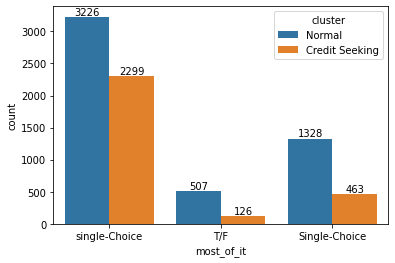

In [170]:
temp
ax = sns.countplot(data=temp,x = 'most_of_it', hue='cluster')
for container in ax.containers:
    ax.bar_label(container)

In [171]:
clusters_attributes = [
    "Percentage_incorrects",
    "Percentage_corrects",
    "percent_consecutive_incorrect_interactions",  #This is the proved one to work
    'percent_consecutive_correct_interactions',
    "time_spent_incorrect_single",
    "n_incorrect_attempts_single",
    "n_correct_attempts_single",  
    #'n_consecutive_incorrects_single', # Is number of solutions increasing, increasing incorrects
    'questions_incorrect_single', # []
    "questions_correct_single", # [] , Probably will contain incorrects to 
    "choices_single", #General all  
    "solutions_single" ,  #General all  
    'n_interactions',
    'time_spent_single'# How much single is affecting out of all 
]

In [172]:
def get_n_two_conseuctive_incorrect(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "X" and flag == False:
            flag = True
        elif activity == "X" and flag == True:
            cnt += 1
        elif activity != "X":
            flag = False
    return cnt

def get_n_two_conseuctive_correct(activities):
    cnt = 0
    flag = False
    for activity in activities:
        if activity == "Crrct" and flag == False:
            flag = True
        elif activity == "Crrct" and flag == True:
            cnt += 1
        elif activity != "Crrct":
            flag = False
    return cnt

def get_n_incorrect(activities):
    cnt = 0
    for activity in activities:
        if activity == "X" :
            cnt+=1
    return cnt


def get_n_correct(activities):
    cnt = 0
    for activity in activities:
        if activity == "Crrct" :
            cnt+=1
    return cnt

In [ ]:
one_row = []
sessions_attributes = []
sessions_attributes_with_user_frameset = []
activity_counter = 0
times_taken_for_incorrect_attempt = []
session_activities = []
time_spent_incorrect_single = [] ; time_spent_single = []
n_incorrect_attempts_single = 0 ; n_correct_attempts_single = 0 ; n_consecutive_incorrects_single = 0 
questions_incorrect_single = set() ; questions_correct_single =set()
choices_single = [] ; solutions_single =[]; 
n_interactions = 0 # Includes single and non-single, for single only sum what we have in n_incorrect and n_correct attempts

nextt = None

for idx in range(1,len(sessions_interactions_all)):
    
    interaction = sessions_interactions_all.iloc[idx]
    if idx != len(sessions_interactions_all) - 1:
        next_interaction =  sessions_interactions_all.iloc[idx+1]
        
    activity = interaction['activity_name']
    question_id = interaction['question_id']
    frameset_name = interaction['curr_frameset_name']
    # If the interaction is SESSION_END then add the prev_session number, and move to the next iteration
    if next_interaction.session_number != interaction.session_number and activity_counter > 2:
        # Here we have been adding all interactions of one session to the list activities
        n_consecutive_incorrects = get_n_two_conseuctive_incorrect(session_activities)
        n_consecutive_corrects =   get_n_two_conseuctive_correct(session_activities)
        n_incorrects = get_n_incorrect(session_activities) #becuase some sessions such as {Crrct --> X --> Crrt --> END_SESSION} will has zero value which doesn't represnt anything about the session
        n_corrects = get_n_correct(session_activities)
        percent_consecutive_incorrect_interactions = n_consecutive_incorrects/len(session_activities)
        percent_consecutive_correct_interactions  = n_consecutive_corrects/len(session_activities)
        
        
        one_row = [n_incorrects/len(session_activities), n_corrects/len(session_activities), round(percent_consecutive_incorrect_interactions,3), round(percent_consecutive_correct_interactions,3), 
                   time_spent_incorrect_single, n_incorrect_attempts_single, n_correct_attempts_single, questions_incorrect_single, questions_correct_single, 
                   choices_single, solutions_single, activity_counter,time_spent_single ]
        sessions_attributes.append( one_row )  # Note the current event is a new session, so when you add to attributes, only access the prev iteration values
        sessions_attributes_with_user_frameset.append([interaction['user_id'], interaction['session_number'], interaction['curr_frameset_name']]+ one_row)  # Adding more info to the row
     
    if activity == 'SESSION_END': # Regardless of the activity_counter
        activity_counter = 0
        session_activities = []
        time_spent_incorrect_single = [];  time_spent_single = []
        n_incorrect_attempts_single = 0 ; n_correct_attempts_single = 0 ; n_consecutive_incorrects_single = 0 
        questions_incorrect_single = set() ; questions_correct_single =set()
        choices_single = [] ; solutions_single =[]; 
        n_interactions = 0
        continue # Move directly to the next iteration
    
    session_activities.append(activity)
    activity_counter += 1
    
    
    if interaction['frameset-qID'] in questions_detailed_single_dict:
        if activity_counter!=1 and activity =='X':
            time_spent_incorrect_single.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if activity_counter!=1 :
            time_spent_single.append((interaction['timestamp'] - prev['timestamp']).total_seconds())
        if interaction['question_id'] not in questions_correct_single and interaction['question_id'] not in questions_incorrect_single:
            choices_single.append(questions_detailed_single_dict[interaction['frameset-qID']])
            solutions_single.append((2**questions_detailed_single_dict[interaction['frameset-qID']])-1) 
        if activity =='X':
            n_incorrect_attempts_single+=1;
            questions_incorrect_single.add(interaction['question_id'])
        if activity =='Crrct':
            n_correct_attempts_single+=1;
            questions_correct_single.add(interaction['question_id'])

    prev = interaction


In [570]:
def find_median(listt):
    listt = sorted(listt)
    return listt[round(len(listt)/2)], round(len(listt)/2)

def select_question_and_nchoices(session_number):
    session_interactions = sessions_interactions_all[sessions_interactions_all.session_number == session_number]
    n_session_interactions = len(session_interactions)
    n_choices = []
    questions_ids = session_interactions['question_id'].unique()
    frameset_qIDs = session_interactions['frameset-qID'].unique()
    single_question_IDs = []
    for qid, frameset_qid in zip(questions_ids,frameset_qIDs):
        if frameset_qid in questions_detailed_single_dict:
            n_choices.append(questions_detailed_single_dict[frameset_qid])
            single_question_IDs.append(qid)
    if n_choices == []:
        return 0 , 0
    median, idx = find_median(n_choices)
    return  median, single_question_IDs[idx]
    # return n_choices, single_question_IDs, median, single_question_IDs[idx]
    
session_numbers = sessions_interactions_all['session_number'].unique()
sessions_attributes_with_user_frameset = []


for session_number in session_numbers:
    n_choices, question_id = select_question_and_nchoices(session_number)
    if n_choices==0:
        continue
    session_interactions = sessions_interactions_all[(sessions_interactions_all.session_number == session_number) & (sessions_interactions_all.question_id == question_id)]
    n_incorrect = 0
    n_correct = 0
    
    for idx, interaction in session_interactions.iterrows():
        activity = interaction['activity_name']
        if activity =='X':
            n_incorrect+=1;
        if activity =='Crrct':
            n_correct+=1;

            sessions_attributes_with_user_frameset.append([interaction['user_id'], interaction['session_number'], interaction['curr_frameset_name'], n_choices, question_id, n_incorrect, n_correct])    

In [579]:
# The new version
sessions_attributes_fine_grained2 = pd.DataFrame(sessions_attributes_with_user_frameset, columns = ['user_id', 'session_number' , 'curr_frameset_name','n_choices', 'question_id', 'n_incorrect', 'n_correct'])
sessions_attributes_fine_grained2 = pd.merge(
        sessions_attributes_fine_grained2, clustered_sessions_all[["session_number",'cluster', 'u']], left_on="session_number", right_on="session_number", how="inner"
    )

In [ ]:
sessions_attributes_fine_grained = pd.DataFrame(sessions_attributes_with_user_frameset, columns = ['user_id', 'session_number' , 'curr_frameset_name'] + clusters_attributes)

In [ ]:
sessions_attributes_fine_grained.columns # Contains everything we need now for coarse and fine grained attributes

In [ ]:
sessions_attributes_fine_grained = pd.merge(
        sessions_attributes_fine_grained, clustered_sessions_all[["session_number",'cluster', 'u']], left_on="session_number", right_on="session_number", how="inner"
    )

In [ ]:
# Remove sessions that doesn't contain single questions
sessions_attributes_fine_grained['n_single'] = sessions_attributes_fine_grained['n_correct_attempts_single'] + sessions_attributes_fine_grained['n_correct_attempts_single']

In [ ]:
# sessions_attributes_fine_grained_single --> Only single sessions
sessions_attributes_fine_grained_single = sessions_attributes_fine_grained[sessions_attributes_fine_grained['n_single']!=0]

In [ ]:
sessions_attributes_fine_grained_single.columns

In [ ]:
# We need some analysis on the dataset question types to compare between them before digging into the subsections

In [ ]:
# sessions_attributes_fine_grained_single['single_choices_mode'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row: stats.mode(row)[0][0] )
sessions_attributes_fine_grained_single['single_choices_max'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row: int(np.max(row)))
sessions_attributes_fine_grained_single['single_choices_median'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row: int(np.median(row)))
sessions_attributes_fine_grained_single['single_choices_mean'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row: round(np.mean(row)))
sessions_attributes_fine_grained_single['single_choices_sum'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row: int(np.sum(row)))
sessions_attributes_fine_grained_single['single_solutions_median'] = sessions_attributes_fine_grained_single['solutions_single'].apply(lambda row: int(np.median(row)))
sessions_attributes_fine_grained_single['single_solutions_mean'] = sessions_attributes_fine_grained_single['solutions_single'].apply(lambda row: int(np.mean(row)))
sessions_attributes_fine_grained_single['time_spent_incorrect_single_sum'] = sessions_attributes_fine_grained_single['time_spent_incorrect_single'].apply(lambda row: int(np.sum(row)))

In [ ]:
sessions_attributes_fine_grained_single.pivot_table(columns='cluster',index='single_choices_median',aggfunc=len,values=['Percentage_corrects'])

In [ ]:
sessions_attributes_fine_grained_single['time_spent_incorrect_single_sum'] = sessions_attributes_fine_grained_single['time_spent_incorrect_single'].apply(lambda row: int(np.sum(row)))
sessions_attributes_fine_grained_single['time_spent_single_sum'] = sessions_attributes_fine_grained_single['time_spent_single'].apply(lambda row: int(np.sum(row)))

In [ ]:
sessions_attributes_fine_grained_single['n_single_questions'] = sessions_attributes_fine_grained_single['choices_single'].apply(lambda row:len(row))


In [ ]:
sessions_attributes_fine_grained_single['time_spent_single_avg'] = sessions_attributes_fine_grained_single['time_spent_single'].apply(lambda row: (np.median(row)))

# Correlation Between N-Question single in a session and probability of it classified as credit-seeking

In [437]:
sessions_attributes_fine_grained_single.columns

Index(['user_id', 'session_number', 'curr_frameset_name',
       'Percentage_incorrects', 'Percentage_corrects',
       'percent_consecutive_incorrect_interactions',
       'percent_consecutive_correct_interactions',
       'time_spent_incorrect_multi', 'n_incorrect_attempts_multi',
       'n_correct_attempts_multi', 'questions_incorrect_multi',
       'questions_correct_multi', 'choices_multi', 'solutions_multi',
       'n_interactions', 'time_spent_multi', 'cluster', 'u', 'n_multi',
       'multi_choices_max', 'multi_choices_median', 'multi_choices_mean',
       'multi_choices_sum', 'multi_solutions_median', 'multi_solutions_mean',
       'time_spent_incorrect_multi_sum', 'time_spent_multi_sum',
       'n_multi_questions', 'time_spent_multi_avg'],
      dtype='object')

In [328]:
sessions_attributes_fine_grained_single.to_csv('sessions_attributes_fine_grained_single.csv')

In [438]:
# I find the solution, for each choice number, get the number of credit-seeking and actively-learning in that session
crsk_temp1 =[0]*11
normal_temp2 = [0]*11

for index, row in sessions_attributes_fine_grained_single.iterrows():
    for num in row['choices_single']:
        if row.cluster == 'Credit Seeking':
            crsk_temp1[num-1]+=1;
        elif row.cluster == 'Normal':
            normal_temp2[num-1]+=1


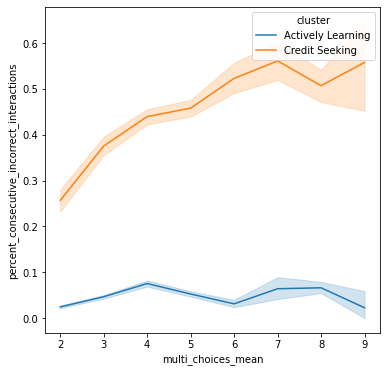

In [466]:
Y = "u" 
Y = "percent_consecutive_incorrect_interactions" 
X = "single_choices_mean"
# res = stats.linregress(sessions_attributes_fine_grained_single[X], sessions_attributes_fine_grained_single[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_single[X], y=sessions_attributes_fine_grained_single[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(6,6))

# gfg = sns.histplot(data=sessions_attributes_fine_grained_single, x=X,hue='u', singleple="dodge",stat="percent", shrink=.8,)# bins=30)
gfg = sns.lineplot(data=sessions_attributes_fine_grained_single, x=X, y=Y , hue='cluster')# bins=30)
# gfg = sns.lineplot(x=sessions_attributes_fine_grained_single[X], y=res.intercept + res.slope * sessions_attributes_fine_grained_single[X])

gfg.set(
    # xlabel="Percentage of credit seeking sessions per student",
    # ylabel="Final score",
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')

plt.show()
# fig.savefig("single-Correlation.pdf", facecolor="white",dpi=500)

# It means whether there are singleple number of choices or not, we may classifiy it as credit seeking or not

In [117]:
sessions_attributes_fine_grained_single[sessions_attributes_fine_grained_single["single_choices_mean"]==1][['curr_frameset_name','n_incorrect_attempts_single',
       'n_correct_attempts_single', 'questions_incorrect_single',
       'questions_correct_single', 'choices_single', 'solutions_single',
       'n_interactions', 'cluster', 'u', 'n_single',]]

,curr_frameset_name,n_incorrect_attempts_multi,n_correct_attempts_multi,questions_incorrect_multi,questions_correct_multi,choices_multi,solutions_multi,n_interactions,cluster,u,n_multi
36,ChomskyNormalFormFF,4,11,"{0, 3, 5, 7}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",16,Normal,0.035129,22
57,ChomskyNormalFormFF,1,11,{2},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",13,Normal,0.049238,22
91,ChomskyNormalFormFF,3,12,"{2, 11, 4}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",17,Normal,0.025785,24
129,ChomskyNormalFormFF,10,5,{6},"{6, 7, 8, 10, 11}","[2, 1, 1, 1, 2]","[3, 1, 1, 1, 3]",16,Credit Seeking,0.988122,10
150,ChomskyNormalFormFF,0,11,{},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",12,Normal,0.091837,22
181,ChomskyNormalFormFF,4,11,"{11, 3, 4, 5}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",16,Normal,0.045145,22
198,ChomskyNormalFormFF,0,11,{},"{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",13,Normal,0.049955,22
260,ChomskyNormalFormFF,0,6,{},"{6, 7, 8, 10, 11}","[2, 1, 1, 1, 2]","[3, 1, 1, 1, 3]",7,Normal,0.142739,12
336,ChomskyNormalFormFF,5,11,"{0, 11, 3, 4}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",17,Normal,0.093601,22
380,ChomskyNormalFormFF,2,11,"{2, 5}","{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11}","[3, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]","[7, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3]",14,Normal,0.021059,22


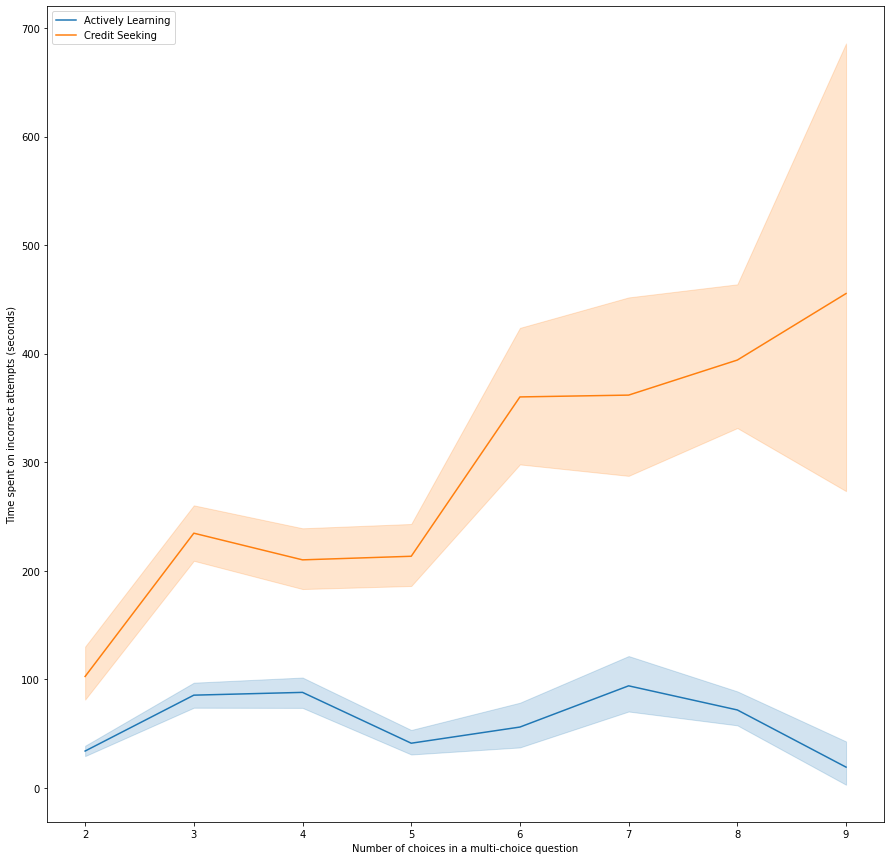

In [595]:
Y = "time_spent_incorrect_single_sum" 
X = "single_choices_median"
# res = stats.linregress(sessions_attributes_fine_grained_single[X], sessions_attributes_fine_grained_single[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_single[X], y=sessions_attributes_fine_grained_single[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(15,15))

gfg = sns.lineplot(data=sessions_attributes_fine_grained_single, x=X, y=Y , hue='cluster',markers=True,dashes=False)# bins=30)

gfg.set(
    xlabel="Number of choices in a single-choice question",
    ylabel="Time spent on incorrect attempts (seconds)"
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')
plt.legend(loc='upper left')

plt.show()
fig.savefig("single-choice-median-time-incorrect.pdf", facecolor="white",dpi=500)

# It means whether there are singleple number of choices or not, we may classifiy it as credit seeking or not

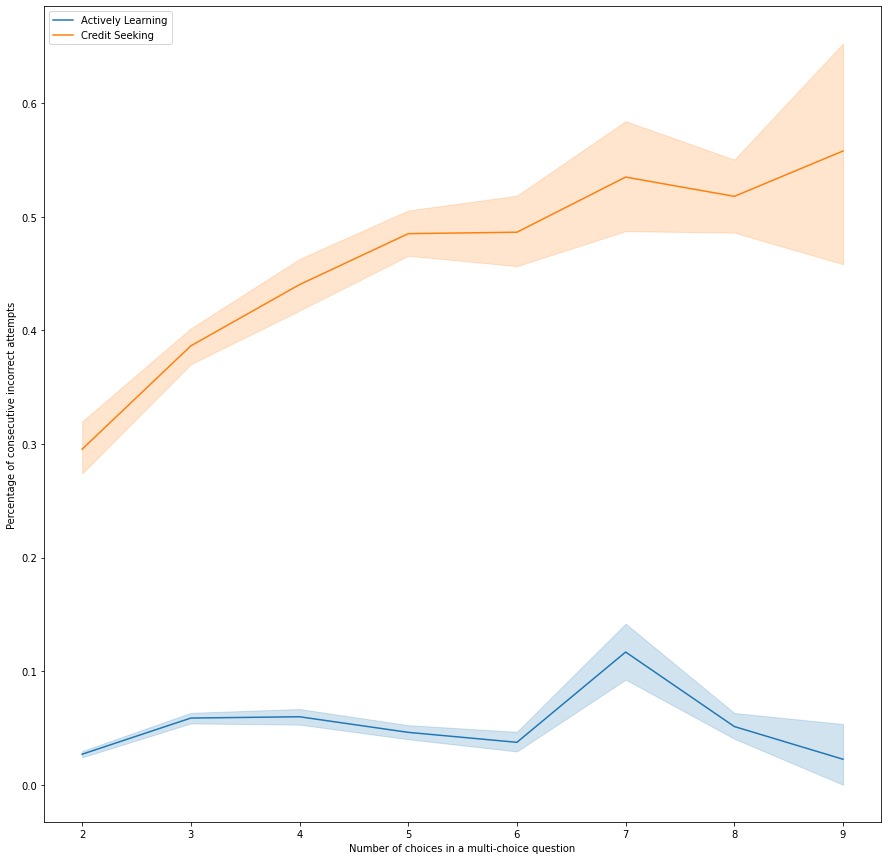

In [596]:
Y = "percent_consecutive_incorrect_interactions" 
X = "single_choices_median"
# res = stats.linregress(sessions_attributes_fine_grained_single[X], sessions_attributes_fine_grained_single[Y])
# rvalue, pvalue = stats.pearsonr(x=sessions_attributes_fine_grained_single[X], y=sessions_attributes_fine_grained_single[Y])
# print(f"R: {res.rvalue}")
# print("P-value", pvalue)
fig, axs = plt.subplots(figsize=(15,15))

# gfg = sns.histplot(data=sessions_attributes_fine_grained_single, x=X,hue='u', singleple="dodge",stat="percent", shrink=.8,)# bins=30)
gfg = sns.lineplot(data=sessions_attributes_fine_grained_single, x=X, y=Y , hue='cluster')# bins=30)
# gfg = sns.lineplot(x=sessions_attributes_fine_grained_single[X], y=res.intercept + res.slope * sessions_attributes_fine_grained_single[X])

gfg.set(
    xlabel="Number of choices in a single-choice question",
    ylabel="Percentage of consecutive incorrect attempts",
)
# plt.legend(loc='upper right',  frameon=True,  shadow=True, title='r = -0.269\np-value = 0.002')
plt.legend(loc='upper left')
plt.show()
fig.savefig("single-choice-median-consecutive-percentage-incorrect.pdf", facecolor="white",dpi=500)

# It means whether there are singleple number of choices or not, we may classifiy it as credit seeking or not